# self-attention

## setup

In [2948]:
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2949]:
EMBED_SIZE = 20
N_HEADS = 5
VOCAB_SIZE = 11
HIDDEN_SIZE = 32
CONTEXT_SIZE = 10
MAGIC_TOKEN = VOCAB_SIZE - 1
EPOCHS = 10000
LEARNING_RATE = 3e-4
DROPOUT = 0.1
TRAINING_SET_SIZE = 10000

In [2950]:
# X, Y = [], []

# for i in range(11000):
#   magic_token_idx = random.randint(1, CONTEXT_SIZE/2 - 1)
#   x = [random.randint(1, VOCAB_SIZE - 2) for _ in range(magic_token_idx)] + [MAGIC_TOKEN] + [0 for _ in range(CONTEXT_SIZE - magic_token_idx - 1)]
#   y = x[:magic_token_idx+1] + x[:magic_token_idx] + [0 for _ in range(CONTEXT_SIZE - 2 * magic_token_idx - 1)]
#   X.append(x)
#   Y.append(y)

# Xall = torch.tensor(X).to(device)
# Yall = torch.tensor(Y).to(device)

# X = Xall[:10000]
# Y = Yall[:10000]

# Xtest = Xall[10000:]
# Ytest = Yall[10000:]

In [2951]:
# make unique sequences
X, Y = [], []
seqs = set()
pad = [0 for _ in range(CONTEXT_SIZE - 2)]
while len(seqs) < TRAINING_SET_SIZE:
  magic_token_idx = random.randint(1, CONTEXT_SIZE - 2)
  seq = tuple(random.randint(1, VOCAB_SIZE - 2) for _ in range(magic_token_idx))
  if len(seq) >= 2 and seq[1] == 9: continue # experiment with out of distribution data
  if len(seq) >= 3 and seq[2] == 9: continue # experiment with out of distribution data
  if len(seq) >= 4 and seq[3] == 9: continue # experiment with out of distribution data
  seqs.add(seq)

seqs = list(seqs)
random.shuffle(seqs)
for seq in seqs:
  seq = list(seq)
  x = (seq + [MAGIC_TOKEN] + pad)[:CONTEXT_SIZE]
  y = (seq + [MAGIC_TOKEN] + seq + pad)[:CONTEXT_SIZE]
  X.append(x)
  Y.append(y)

Xall = torch.tensor(X).to(device)
Yall = torch.tensor(Y).to(device)

split = int(0.9 * TRAINING_SET_SIZE)
X = Xall[:split]
Y = Yall[:split]

Xtest = Xall[split:]
Ytest = Yall[split:]

In [2952]:
# sanity check, count duplicates, should be 0
dup, not_dup = 0, 0
lookup = X.tolist()
for i in Xtest.tolist():
    if i in lookup: dup += 1
    else: not_dup += 1

assert dup == 0 and not_dup == len(Xtest), 'there shouldn\'t be any duplicates'

## code

### RoPE
paper: [RoFormer: Enhanced Transformer with Rotary Position Embedding](https://arxiv.org/pdf/2104.09864.pdf)

In [2953]:
def get_rotation_matrix(m, embed_size=EMBED_SIZE):
  thetas = torch.tensor([10000 ** (-(2 * (i // 2)) / embed_size) for i in range(embed_size)])
  thetas *= m
  rotation = torch.eye(embed_size)
  rotation *= thetas.cos()
  col_vals = torch.arange(0, embed_size, 2)
  row_vals = col_vals + 1
  rotation[col_vals, row_vals] = -thetas.sin()[::2]
  rotation[row_vals, col_vals] = thetas.sin()[::2]
  return rotation.T

def get_rotation_matrices(context_size=CONTEXT_SIZE, embed_size=EMBED_SIZE):
  rotations = [get_rotation_matrix(m, embed_size) for m in range(context_size)]
  return torch.stack(rotations).to(device)

def get_efficient_rotation_matrix(context_size, embed_size=EMBED_SIZE):
  thetas = torch.tensor([10000 ** (-(2 * (i // 2)) / embed_size) for i in range(embed_size)])
  cos_ = [(m * thetas).cos() for m in range(context_size)]
  sin_ = [(m * thetas).sin() for m in range(context_size)]
  return torch.stack(cos_).to(device), torch.stack(sin_).to(device)

def compute_efficient_rotation_matrices(x):
  B, C, E = x.shape
  cos_, sin_ = get_efficient_rotation_matrix(C, E)
  x1 = x[:, :, ::2]
  x2 = -x[:, :, 1::2]
  y = torch.stack((x2, x1), dim=-1).view(B, C, E)
  rotated = x * cos_ + y * sin_
  return rotated

def apply_rope(x, fast=True):
  if fast: return compute_efficient_rotation_matrices(x)
  B, C, E = x.shape
  return (x.view(B, C, 1, E) @ get_rotation_matrices(C, E)).view(B, C, E)

def test_implems():
  x = torch.arange(16).view(2, 2, 4).float().to(device)
  B, C, E = x.shape

  rotated_matrix = (x.view(B, C, 1, E) @ get_rotation_matrices(C, E)).view(B, C, E)
  rotated_fast = compute_efficient_rotation_matrices(x)
  assert torch.allclose(rotated_matrix, rotated_fast), 'matrix() and fast() are not equal'

test_implems()
# get_rotation_matrices(embed_size=6)

### ALiBi
paper: [Train Short, Test Long: Attention with Linear Biases Enables Input Length Extrapolation](https://arxiv.org/pdf/2108.12409.pdf)

In [2954]:
def alibi_distances(n_context, is_encoder=True):
    diag_dists = torch.cumsum(torch.triu(torch.ones(n_context, n_context).to(device)), dim=1) * -1
    diag_dists[diag_dists != 0] += 1

    dists = diag_dists.transpose(-2, -1)
    if is_encoder:
        dists = dists + diag_dists
    return dists

def alibi_scalers(n_heads):
    # vector with M values in a geometric sequence (starting at 2^-(8/n)) where n == number of heads.
    m_vector = 2 ** -((8 / n_heads) * torch.arange(1, n_heads + 1).to(device))
    return m_vector.view(-1, 1, 1) # reshape to broadcast correctly

def apply_alibi(correlation, is_encoder=True):
    n_context = correlation.shape[-1]
    n_heads = correlation.shape[-3]
    scaled_dists = alibi_scalers(n_heads) * alibi_distances(n_context, is_encoder)
    return correlation + scaled_dists

# alibi_distances(4, is_encoder=False)
# alibi_scalers(8)

### transformer

In [2955]:
activations = {}

def create_positional_encoding(context_size=CONTEXT_SIZE, embed_size=EMBED_SIZE):
  '''sinusoidal positional encoding - see Attention is all you need'''
  position = torch.arange(context_size).unsqueeze(1)
  div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size))
  positional_encoding = torch.zeros(context_size, embed_size)
  positional_encoding[:, 0::2] = torch.sin(position * div_term)
  positional_encoding[:, 1::2] = torch.cos(position * div_term)
  return positional_encoding.to(device)

class MultiheadAttention(nn.Module):
  def __init__(self, n_heads, embed_size, dropout):
    super().__init__()
    assert embed_size % n_heads == 0, f'{embed_size=} should be divisible by {n_heads=}'
    self.n_heads = n_heads
    self.embed_size = embed_size
    self.dropout_rate = dropout
    self.qkv = nn.Linear(embed_size, embed_size * 3, bias=False) # generate Q, K, V all at once
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(embed_size)

  def forward(self, x):
    B, C, E = x.shape
    # pre-layernorm
    x = self.ln(x)
    # q, k, v = self.qkv(x).split(self.embed_size, dim=-1)
    q, k, v = self.qkv(x).chunk(3, dim=-1)
    # --- RoPE ---
    # q = apply_rope(q)
    # k = apply_rope(k)
    
    # split heads
    q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    # fast version
    # y = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_rate if self.training else 0.)
    # by hand
    correlation = q @ k.transpose(-2, -1)
    correlation = correlation / math.sqrt(k.shape[-1])

    # --- ALiBi ---
    # correlation = apply_alibi(correlation)

    correlation = F.softmax(correlation, dim=-1)
    activations['x'] = correlation.detach()
    correlation = F.dropout(correlation, p=self.dropout_rate, training=self.training)
    y = correlation @ v
    # combine heads
    y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size)
    y = self.dropout(y)
    return y

class Attention(nn.Module):
  def __init__(self, embed_size, dropout):
    super().__init__()
    self.w_key = torch.nn.Linear(embed_size, embed_size, bias=False)
    self.w_query = torch.nn.Linear(embed_size, embed_size, bias=False)
    self.w_value = torch.nn.Linear(embed_size, embed_size, bias=False)
    self.ln = nn.LayerNorm(embed_size)
    self.attn_dropout = nn.Dropout(dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    # pre-layernorm
    x = self.ln(x)
    # generate K,Q,V
    key = self.w_key(x)
    query = self.w_query(x)
    value = self.w_value(x)
    # pre-layernorm
    x = self.ln(x)
    # do the attention
    correlation = query @ key.transpose(-2, -1)
    correlation = correlation / math.sqrt(key.shape[-1])
    correlation = F.softmax(correlation, dim=-1)
    activations['x'] = correlation.detach()
    correlation = self.attn_dropout(correlation)
    new_embedding = correlation @ value
    # post-layernorm
    # new_embedding = self.ln(new_embedding)
    new_embedding = self.dropout(new_embedding)
    return new_embedding

class Net(nn.Module):
  def __init__(self, learned_positional_encoding=True, multihead=False, n_heads=N_HEADS, embed_size=EMBED_SIZE, dropout=DROPOUT, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE, context_size=CONTEXT_SIZE):
    super().__init__()
    self.use_learned_positional_encoding = learned_positional_encoding
    self.context_size = context_size
    # net
    self.token_embedding = nn.Embedding(vocab_size, embed_size)
    self.positional_embedding = nn.Embedding(context_size, embed_size) if learned_positional_encoding else create_positional_encoding()
    self.attention = MultiheadAttention(n_heads, embed_size, dropout=dropout) if multihead else Attention(embed_size, dropout=dropout)
    self.ff = nn.Sequential(
      nn.LayerNorm(embed_size), # pre-layernorm
      nn.Linear(embed_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, embed_size),
      # nn.LayerNorm(EMBED_SIZE), # post-layernorm
      nn.Dropout(dropout)
    )

    self.attention2 = MultiheadAttention(n_heads, embed_size, dropout=dropout) if multihead else Attention(embed_size, dropout=dropout)
    self.ff2 = nn.Sequential(
      nn.LayerNorm(embed_size), # pre-layernorm
      nn.Linear(embed_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, embed_size),
      # nn.LayerNorm(EMBED_SIZE), # post-layernorm
      nn.Dropout(dropout)
    )

    self.head = nn.Linear(embed_size, vocab_size)

  def forward(self, x):
    # (batch_size, context_size)
    x = self.token_embedding(x)  # (batch_size, context_size, embedding_size)
    # positional encoding
    x = x + self.get_positional_embedding()
    # attention
    x = x + self.attention(x)
    # feed forward
    x = x + self.ff(x)

    # x2
    x = x + self.attention(x)
    x = x + self.ff(x)

    # head
    x = self.head(x)
    return x
  
  def get_positional_embedding(self):
    if self.use_learned_positional_encoding:
      return self.positional_embedding(torch.arange(0, self.context_size).to(device))
    else:
      return self.positional_embedding
    
  def get_positional_embeddings(self):
    return self.get_positional_embedding().detach().cpu()

In [2956]:
model = Net(learned_positional_encoding=True, multihead=True, n_heads=1).to(device)
positional_embeddings = []

In [2957]:
def train(model, epochs=EPOCHS, lr=LEARNING_RATE):
  model.train()
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    out = model(X)
    loss = F.cross_entropy(out.view(-1, out.shape[-1]), Y.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
      positional_embeddings.append(model.get_positional_embeddings())
    if epoch % 500 == 0:
      print(f'{epoch:5} {loss.item()}')

train(model, epochs=2000)

    0 2.8358747959136963
  500 0.6094689965248108
 1000 0.43229830265045166
 1500 0.2227773666381836


In [2958]:
model.eval()
for x, y, label in [(Xtest, Ytest, 'test'), (X, Y, 'train')]:
    res = model(x).argmax(-1)
    correct = ((res == y).float().sum(-1) == CONTEXT_SIZE).float().sum()
    print(f'accuracy on {label:5}: {correct / len(x)}')
res[:5]

accuracy on test : 0.987000048160553
accuracy on train: 0.9921111464500427


tensor([[ 6,  3,  4,  1,  7,  5, 10,  6,  3,  4],
        [ 3,  7,  2,  8,  5,  9,  6,  4, 10,  3],
        [ 6,  1,  7,  2,  9,  4,  5, 10,  6,  1],
        [ 4,  5,  1,  4,  3,  6,  2, 10,  4,  5],
        [ 3,  7,  7,  1,  7,  3, 10,  3,  7,  7]], device='cuda:0')

tensor([[ 7,  1,  9,  2, 10,  7,  1,  9,  2,  0]], device='cuda:0')


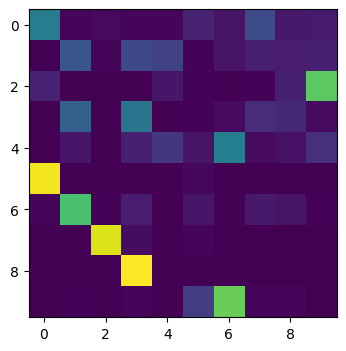

In [2959]:
model.eval()
res = model(torch.tensor([[7,1,9,2,10,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[1,2,10,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,10,0,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,3,4,10,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[7,1,9,10,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[1,2,3,4,5,10,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[1,2,3,4,5,6,10,0,0,0]]).to(device)).argmax(-1)
print(res)

if activations['x'].dim() == 4:
  activations['x'] = activations['x'].squeeze(0)
repeat = activations['x'].shape[0]
fig, ax = plt.subplots(1, repeat, figsize=(12, 4))
if repeat == 1: ax = np.array([ax])
for i in range(repeat):
  ax[i].imshow(activations['x'][i].cpu())

In [2960]:
# save
# ----
# torch.save(model.state_dict(), 'weights/copy-task-500k-epochs.pt')

# load
# ----
# m = Net().to(device)
# m.load_state_dict(torch.load('weights/copy-task-500k-epochs.pt'))

## testing ideas

ideas requiring positional encoding / attention:
1) additions using LLM
2) arithmetic / geometric sequence prediction 1, 3, 5 ? → 7  or 2, 4, 8, ? → 16
3) (BOW?) sort 1, 3, 2, 4, 1 → 1, 1, 2, 3, 4
4) parens summation: (2 2 3) (4 5) → 7, 9
5) substring extraction between markers: 1, 4, 56, 10, 43, 54, 56, 6, 10 → 43, 54, 56, 6

## visualize positional embeddings

### dotproduct / cosine distance

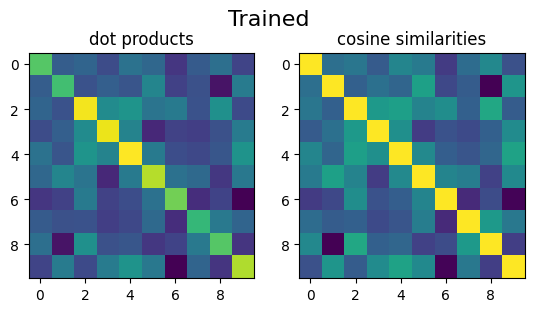

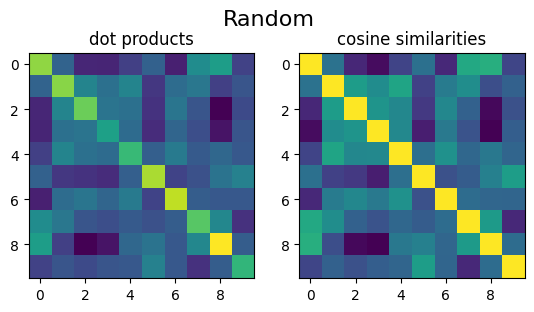

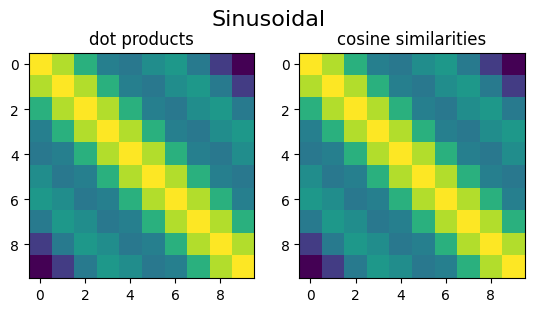

In [2961]:
def plot_positional_embeddings_relations(model, title):
    x = model.get_positional_embeddings()
    dot_products = x @ x.T
    x_norm = x / x.norm(dim=1, keepdim=True)
    cosine_similarities = x_norm @ x_norm.T
    # plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(dot_products)
    ax[0].set_title('dot products')
    ax[1].imshow(cosine_similarities)
    ax[1].set_title('cosine similarities')
    fig.text(0.5, 0.8, title, ha='center', va='center', fontsize=16)
    plt.show()

m_rand = Net(learned_positional_encoding=True).to(device)
m_sin = Net(learned_positional_encoding=False).to(device)
plot_positional_embeddings_relations(model, 'Trained')
plot_positional_embeddings_relations(m_rand, 'Random')
plot_positional_embeddings_relations(m_sin, 'Sinusoidal')

### PCA

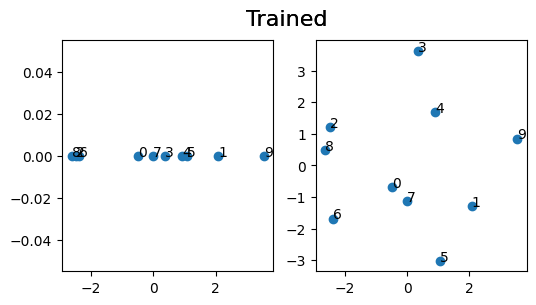

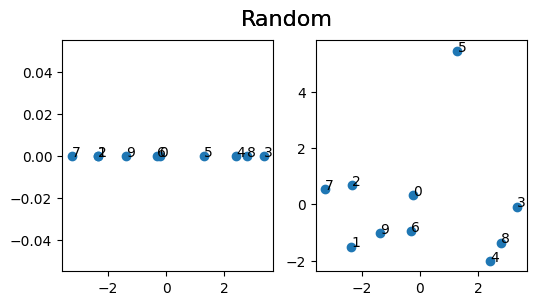

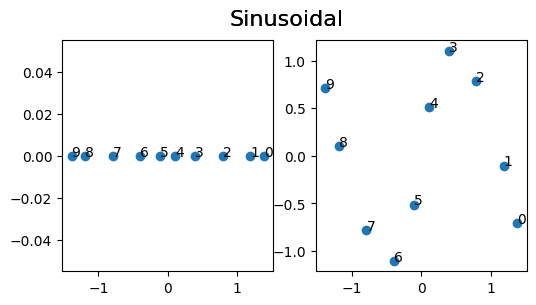

In [2962]:
def plot_positional_embeddings_pca(model, title='', figsize=(6, 3)):
    def reduce_dims(x, dim):
        pca = PCA(n_components=dim)
        y = pca.fit_transform(x)
        if dim == 1: return y[:, 0], np.zeros_like(y[:, 0])
        return y[:, 0], y[:, 1]

    x = model.get_positional_embeddings()
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for j, dim in enumerate([1, 2]):
        xs, ys = reduce_dims(x, dim)
        # plot
        ax[j].scatter(xs, ys, label=f'pca dim={dim}')
        for i in range(xs.shape[0]):
            ax[j].annotate(f'{i}', xy=(xs[i], ys[i]))
        fig.text(0.5, 0.95, title, ha='center', va='center', fontsize=16)

m_rand = Net(learned_positional_encoding=True).to(device)
m_sin = Net(learned_positional_encoding=False).to(device)
plot_positional_embeddings_pca(model, 'Trained')
plot_positional_embeddings_pca(m_rand, 'Random')
plot_positional_embeddings_pca(m_sin, 'Sinusoidal')

### over time

In [2963]:
def get_frame(pe, ax):
    def f(step):
        x = pe[step]
        gamma = 1/(F.pdist(torch.tensor(x))).median().float().item()
        xs, ys = x[:, 0], x[:, 1]
        ax.clear()
        ax.set_title(f'step {step} gamma {gamma:.4f}')
        ax.scatter(xs, ys, label='')
        for i in range(xs.shape[0]):
            ax.annotate(f'{i}', xy=(xs[i], ys[i]))
    return f

def animate_positional_embeddings(pe, figsize=(3, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(pe, ax), frames=len(pe), interval=50, repeat=False)
    plt.close()
    return ani

# pes = positional_embeddings[::10]
# # optional PCA if we are running embeddings with more than 2 dimensions
# if pes[0].shape[-1] > 2:
#     # pes = [PCA(n_components=2).fit_transform(x) for x in pes]
#     pes = [KernelPCA(n_components=2, kernel='rbf', gamma=1/(F.pdist(x)).median().float().item()).fit_transform(x) for x in pes]

# ani = animate_positional_embeddings(pes)
# display(HTML(ani.to_jshtml())) # display inline

In [2964]:
# ani.save('gifs/learned-2d-short.gif', fps=20) # save to disk

In [2965]:
x = torch.tensor([1, 3, 5]).view(1, 1, 3)
y = torch.tensor([-2, -4, -6]).view(1, 1, 3)

# Stack x and y along a new dimension
stacked = torch.stack((x, y), dim=-1)

# Reshape the stacked tensor to a 1D tensor
interleaved = stacked.reshape(1, 1, 6)
interleaved

tensor([[[ 1, -2,  3, -4,  5, -6]]])

In [2966]:
x = torch.tensor([[[1, 3, 5]],[[10, 30, 50]]]).shape
# y = torch.tensor([-2, -4, -6]).view(1, 1, 3)

# # Stack x and y along a new dimension
# stacked = torch.stack((x, y), dim=-1)

# # Reshape the stacked tensor to a 1D tensor
# interleaved = stacked.reshape(1, 1, 6)
# interleaved